In [1]:
#!pip install apafib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

In [3]:
import pandas as pd
try:
    from apafib import load_medical_costs
    med_cost_data = load_medical_costs()
except:
    med_cost_data = pd.read_csv('insurance.csv')

### Divide el conjunto de datos en entrenamiento y test (70 %/30 %). Haz una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Describe las cosas que hayas visto que te parezcan interesantes. Transforma las variables adecuadamente para poder ajustar un modelo de regresión tanto el conjunto de entrenamiento como el de test.


In [4]:
med_cost_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
med_cost_data.shape

(1338, 7)

Se puede observar que la correlación entre las variables es baja en general, excepto entre smoker y charges (la variable objetivo). Esto probablemente se deba a que al ser fumador y tener altas probabilidades de tener cáncer, los seguros médicos te aumentan la tasa.

#### Preproceso

In [6]:
med_cost_data['sex'].replace(['male', 'female'], [0, 1], inplace=True)
med_cost_data['smoker'].replace(['no', 'yes'], [0, 1], inplace=True)
med_cost_data['region'].replace(['northeast', 'southeast', 'southwest', 
                                 'northwest'], [0, 1, 2, 3], inplace=True)

In [7]:
med_cost_data

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,2,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,3,21984.47061
4,32,0,28.880,0,0,3,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,3,10600.54830
1334,18,1,31.920,0,0,0,2205.98080
1335,18,1,36.850,0,0,1,1629.83350
1336,21,1,25.800,0,0,2,2007.94500


#### Split

In [8]:
X = med_cost_data.loc[:,med_cost_data.columns != 'charges']
y = med_cost_data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

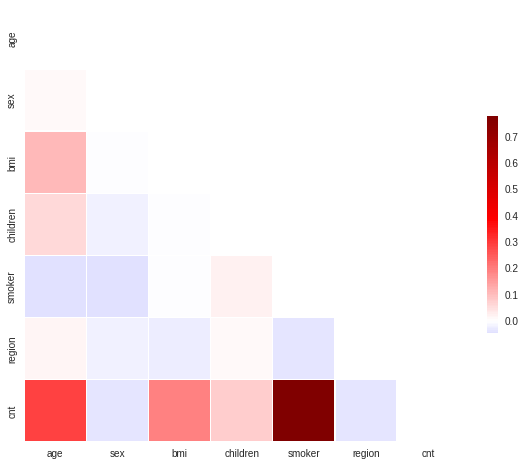

In [9]:
trainData = X_train.copy()
trainData = trainData.assign(cnt=y_train.values)
corr = trainData.corr()
fig = plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Ajusta un modelo de regresión lineal para predecir la variable objetivo y estima la calidad de la regresión. ¿Te parece suficientemente bueno el resultado? Representa los residuos y comenta que aparece.

In [11]:
lr = LinearRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

In [12]:
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [3700.7265419   -71.72266617 1993.51003252  524.94735723 9585.94897699
 -164.46608369]
Interceptor: 
 13379.157306773504


In [13]:
print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.7678126013008374


La calidad de la regresión podría ser mejor, ya que hay un 24% de variación en los datos que no queda explicada.

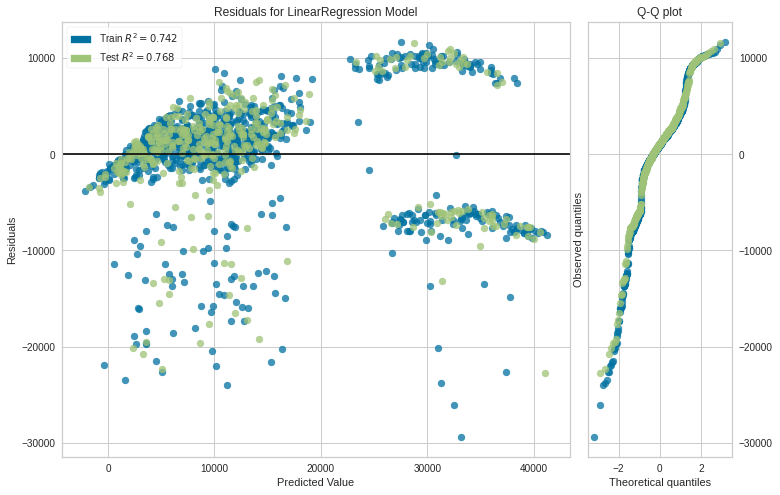

In [14]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz2 = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

En la gráfica de residuos podemos apreciar que hay un valor extremo mayor a 60000, pero que quitando eso la recta se aproxima suficientemente bien a la nube de puntos.

### La relación entre las variables del conjunto de datos y la variable objetivo podrían ser no lineal. Usa la función PolynomialFeatures de scikit-learn para añadir características al conjunto de datos que correspondan a polinomios de grado 2.

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [16]:
X_train_poly

array([[ 1.        ,  1.54446486,  1.02597835, ...,  0.26315789,
        -0.70153392,  1.87016939],
       [ 1.        ,  0.48187425, -0.97467943, ...,  0.26315789,
        -0.24330939,  0.22495795],
       [ 1.        ,  1.04858924,  1.02597835, ...,  0.26315789,
         0.21491514,  0.17551636],
       ...,
       [ 1.        ,  1.33194673, -0.97467943, ...,  0.26315789,
         0.67313966,  1.72184462],
       [ 1.        , -0.15568012,  1.02597835, ...,  3.8       ,
         0.92457569,  0.22495795],
       [ 1.        ,  1.11942861, -0.97467943, ...,  0.26315789,
        -0.24330939,  0.22495795]])

In [17]:
X_test_poly

array([[ 1.        ,  0.41103487,  1.02597835, ...,  0.26315789,
         0.67313966,  1.72184462],
       [ 1.        , -0.22651949,  1.02597835, ...,  0.26315789,
        -0.70153392,  1.87016939],
       [ 1.        ,  1.75698298,  1.02597835, ...,  3.8       ,
         2.66582889,  1.87016939],
       ...,
       [ 1.        , -1.50162823,  1.02597835, ...,  0.26315789,
         0.67313966,  1.72184462],
       [ 1.        ,  1.33194673, -0.97467943, ...,  0.26315789,
         0.21491514,  0.17551636],
       [ 1.        , -1.35994948, -0.97467943, ...,  0.26315789,
        -0.24330939,  0.22495795]])

### Ajusta a estos nuevos datos un modelo de regresión lineal y uno de regresión LASSO y estima la calidad de la regresión. ¿Te parece suficientemente bueno el resultado de los modelos? Representa los residuos y comenta que aparece. ¿Qué modelo te parece mejor? ¿Por qué?

In [18]:
lr2 = LinearRegression()

lr2.fit(X_train_poly,y_train)

y_pred_poly = lr2.predict(X_test_poly)

In [19]:
weights = lr2.coef_
intercept = lr2.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [-2.41311212e+10  3.67041589e+03 -2.50579451e+12  2.02474881e+03
  8.62614284e+02 -1.00100485e+13 -3.21085923e+02  7.93711638e+02
 -1.10599116e+02  2.14015370e+02]
Interceptor: 
 -55791788235627.29


In [20]:
print("R2 score: " , r2_score(y_test, y_pred_poly))

R2 score:  0.8618219565921325


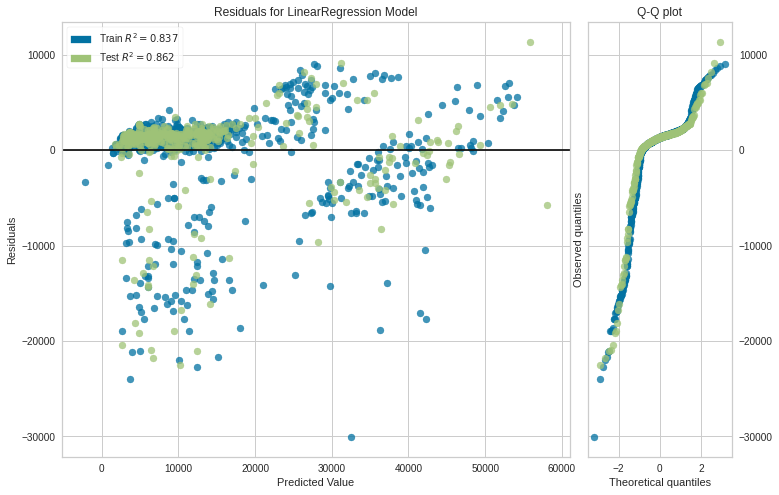

In [21]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz2 = residuals_plot(lr2, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False);

In [22]:
lasso = Lasso()

lasso.fit(X_train_poly, y_train)

y_pred_poly_lasso = lasso.predict(X_test_poly)

In [23]:
weights = lasso.coef_
intercept = lasso.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [   0.         3670.26591707  196.68313136 2023.58646656  859.78319126
 9596.92687666 -319.65240723  791.85741769 -109.54608769  212.73631116]
Interceptor: 
 12579.07325492734


In [24]:
print("R2 score: " , r2_score(y_test, y_pred_poly_lasso))

R2 score:  0.8618549431257976


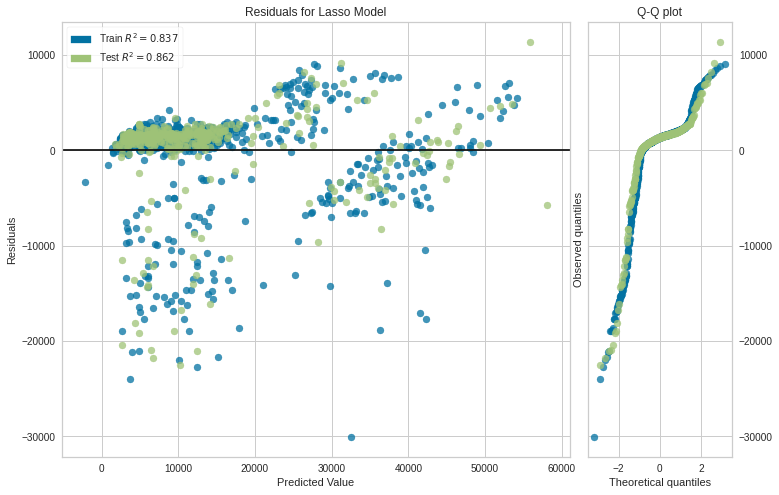

In [25]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz2 = residuals_plot(lasso, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False);

He podido apreciar que al hacer la transformación a polinomios de grado 2, la calidad de la regresión ha mejorado mucho. Podemos observar ahora también que la recta se ajusta muchísimo más a la nube de puntos en los residual plot. No obstante, no hay diferencia apreciable entre usar una regressión normal y una lasso.